# How to: Build a feedforward neural network with TensorFlow Eager

Hello everyone! In this tutorial I am going to build a simple feedforward neural network using the imperative mode of TensorFlow. Hope you will find it useful!

## Step 1: Import useful libraries and enable eager mode
----

In [15]:
# Suppress future warnings
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import TensorFlow and TensorFlow Eager
import tensorflow as tf
import tensorflow.contrib.eager as tfe

# Import function to generate toy classication problem
from sklearn.datasets import make_classification

# Import library for plots
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Enable eager mode
tfe.enable_eager_execution()

## Step 2: Generate toy dataset for multi-classification
----

In [121]:
# Generate toy dataset for classification
# X is a matrix of n_samples x n_features and represents the input features
# y is a vector with length n_samples and represents our targets
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0,
                           random_state=1990, n_clusters_per_class=1,
                           n_classes=3)

## Step 3: Visualize generated dataset
----

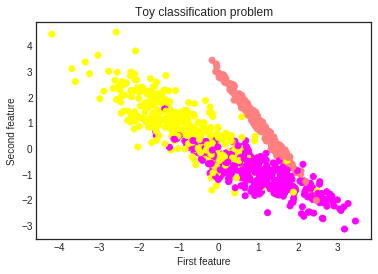

In [122]:
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.spring)
plt.xlabel('First feature')
plt.ylabel('Second feature')
plt.title('Toy classification problem')
plt.show()

## Step 4: Build a single hidden layer neural  network (Linear -> Batchnorm -> ReLU)
----
Our first trial is a simple neural network with a single hidden layer. The batchnornm layer is put before the ReLU activation.

In [214]:
# Transfer data from numpy arrays to tensorflow tensors
X = tf.constant(X)
y = tf.constant(y)

In [215]:
def model(X):
    # Our first hidden layer (Linear -> Batchnorm -> ReLU)
    dense_layer = tf.layers.Dense(5, activation=None)(X)
    batchnorm_layer = tf.layers.batch_normalization(dense_layer, training=True)
    relu_layer = tf.nn.relu(batchnorm_layer)
    # Output layer. Unscaled log probabilities
    output_layer = tf.layers.Dense(3, activation=None)(relu_layer)
    return output_layer

## Step 5: Define loss and optimizer
----
As this is a multi-classification problem, we will be using the softmax cross-entropy loss. Normally, we would have to one-hot encode our targets. To avoid this, we will be using the sparse softmax loss, which takes as an input the raw targets. No need for further processing! HOORAY :smile:.


In [216]:
# Define loss functon
def loss_model(X, y):
    output = model(X)
    return tf.losses.sparse_softmax_cross_entropy(y, output)

In [217]:
# Define optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=3e-4)

In [218]:
# Compute the gradients with respect to the loss function
grad = tfe.implicit_gradients(loss_model)(X, y)

## Step 6: Train the model with gradient descent
----

In [219]:
num_epochs = 30

In [220]:
for i in range(num_epochs):
    # One step of gradient descent
    optimizer.apply_gradients(grad)
    # Compute the loss
    print('Loss at step %d: %f' %(i, loss_model(X, y).numpy()))

Loss at step 0: 0.905205
Loss at step 1: 1.311780
Loss at step 2: 1.925659
Loss at step 3: 1.698206
Loss at step 4: 1.984971
Loss at step 5: 1.138929
Loss at step 6: 1.558862
Loss at step 7: 1.186339
Loss at step 8: 1.000030
Loss at step 9: 1.255122
Loss at step 10: 1.307982
Loss at step 11: 0.758942
Loss at step 12: 1.581575
Loss at step 13: 1.271275
Loss at step 14: 0.917459
Loss at step 15: 0.920722
Loss at step 16: 1.202806
Loss at step 17: 1.321487
Loss at step 18: 1.281239
Loss at step 19: 1.409526
Loss at step 20: 0.815486
Loss at step 21: 1.337142
Loss at step 22: 1.357809
Loss at step 23: 1.115037
Loss at step 24: 1.309586
Loss at step 25: 1.694880
Loss at step 26: 0.741526
Loss at step 27: 1.209865
Loss at step 28: 1.878530
Loss at step 29: 1.097534
